# Restarting simulations

In this tutorial, we simulate slip on a fault with a single velocity-weakening asperity, embedded in a velocity-strengthening (creeping) matrix. After a few years, we restart the simulation from the last snapshot that was written to disk upon terminating the previous simulation.

In [1]:
# Make plots interactive in the notebook
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

# Import QDYN wrapper and plotting library
from qdyn import qdyn
from qdyn import plot_functions as qdyn_plot

To illustrate the restart of a simulation, we take the example of a single asperity

In [2]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
Lasp = 7                    # Length of asperity / nucleation length
L = 5                       # Length of fault / nucleation length
ab_ratio = 0.8              # a/b of asperity
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict

t_restart = 2 * t_yr

""" Step 1: Define simulation/mesh parameters """
# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 0         # Periodic fault
set_dict["TMAX"] = t_restart   # Maximum simulation time [s]
set_dict["NTOUT_LOG"] = 1000   # Save output every N steps
set_dict["NTOUT_OT"] = 10      # Save output every N steps
set_dict["NTOUT_OX"] = 100     # Save output every N steps
set_dict["NXOUT_OX"] = 2       # Snapshot resolution (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["W"] = 50e3           # Loading distance [m]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)

# Setting some (default) RSF parameter values
set_dict["SET_DICT_RSF"]["A"] = 0.9e-2    # Direct effect (will be overwritten later)
set_dict["SET_DICT_RSF"]["B"] = 1e-2      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = set_dict["V_PL"] # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Compute relevant length scales:
# Process zone width [m]
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
# Nucleation length [m]
Lc = Lb / cab_ratio
# Length of asperity [m]
Lasp *= Lc
# Fault length [m]
L *= Lasp

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Set time series output node to the middle of the fault
set_dict["IC"] = N // 2

""" Step 2: Set (default) parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

""" Step 3: override default mesh values """
# Distribute direct effect a over mesh according to some arbitrary function
p.mesh_dict["A"] = set_dict["SET_DICT_RSF"]["B"] * (1 + cab_ratio*(1 - 2*np.exp(-(2*x/Lasp)**6)))

p.set_dict["VERBOSE"] = 0  # Set to 1 if you want log messages on screen

# Write input to qdyn.in
p.write_input()

True

In [3]:
p.run()

True

To get a point of reference, this is what the simulation data looks like up to this point:

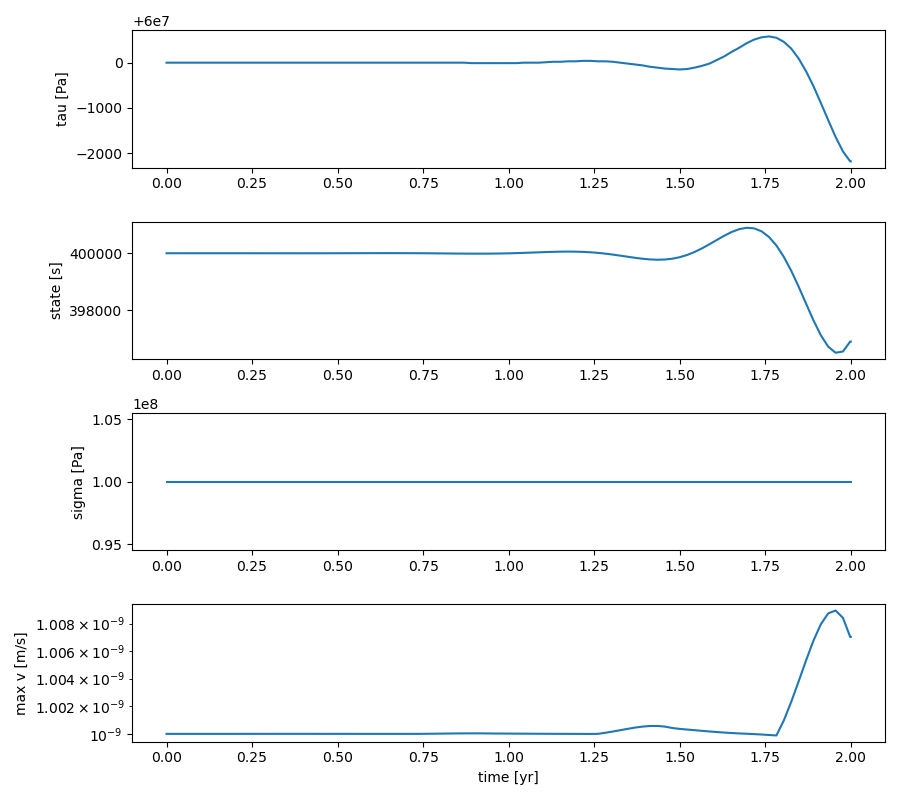

In [4]:
p.read_output(read_ox=False, read_ox_last=False)

# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

We can now restart the simulation with a new target time by overwriting the `TMAX` parameter to a higher value, and calling the QDYN executable with `restart=True`. Under the hood, the wrapper will read the state of the fault from the last snapshot (`ox_last`) and create a new `qdyn.in` input file. The new simulation output will then be appended to that of the previous simulation.

In [5]:
p.set_dict["TMAX"] = t_restart + 6 * t_yr
p.run(restart=True)

True

After reading the data, we can now see the seamless continuation of the simulation up to the new target time.

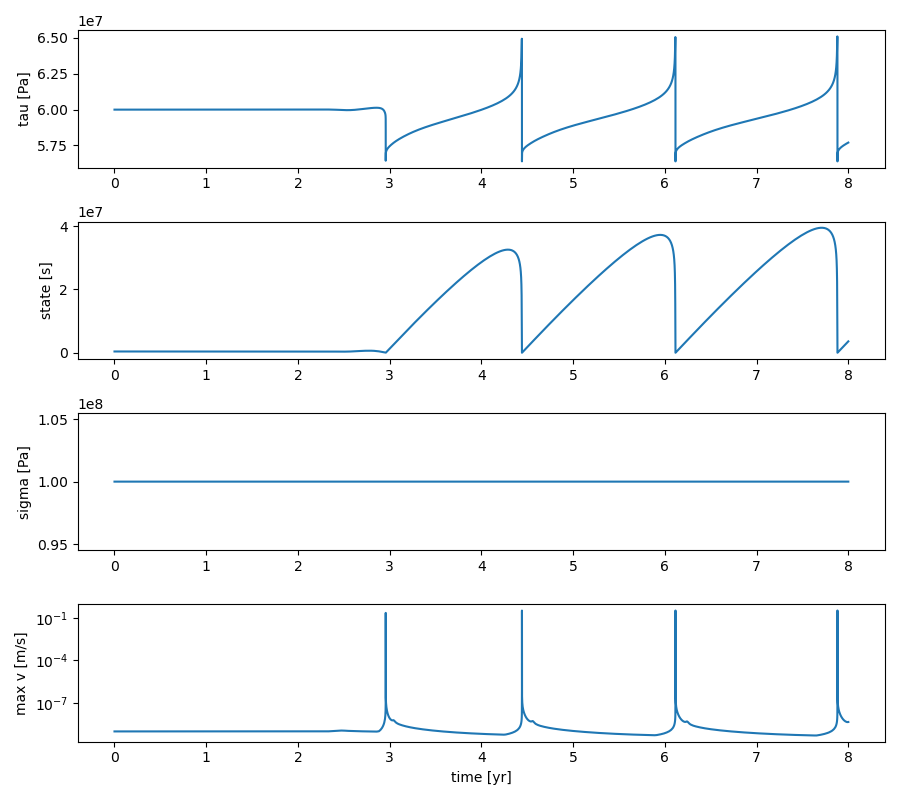

In [6]:
p.read_output(read_ox=False, read_ox_last=False)
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)